# Аналитика стартапа по продаже продуктов питания

Задача- исседовать поведение пользователей мобильного приложения и дать рекомендации по улучшению продукта.

Для выполнения поставленной задачи надо было изучить воронку продаж и исследовать результаты A/A/B-эксперимента по изменению шрифта во всём приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно было выяснить, какой шрифт лучше.

Для анализа предаставлена таблица log_data, содержащая следующую информацию:

    EventName — название события;
    DeviceIDHash — уникальный идентификатор пользователя;
    EventTimestamp — время события;
    ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Содержание

[Библиотеки](#library)

1. [Общая информация о данных](#information)
2. [Предобработка данных](#preparation)
3. [Анализ данных](#analytic)

    1. [Количество видов событий в логе](#count_event)
    2. [Количество уникальных пользователей в логе](#count_users)
    3. [Колиество событий, которые в среднем приходятся на одного пользователя](#count_avg_event)
    4. [Работа с данными времени](#time)
    5. [Обзор пользователей экспериментальных групп](#check_users_for_test)
4. [Воронка событий](#funnel_of_events)
    1. [Обзор событий в логах](#overview_events)
    2. [Работа с пользователями, которые совершают события](#work_with_users)
    3. [Порядк событий](#order_of_events)
    4. [Анализ воронки событий](#work_with_funnel)
5. [Анализ результата A/A/B теста](#analytic_test)
    1. [Обзор пользователей в каждой экспериментальной группе](#overview_group)
    2. [Статистический анализ контрольных групп](#analytic_control_group)
    3. [Статистический анализ группы с изменённым шрифтом и контрольными групп](#analytic_all_group)
    
[Общий вывод](#conclusion)

## Библиотеки  <a id="library"></a>

In [1]:
#для работы с файлом и данными подключим библиотеку pandas 
import pandas as pd
#для работы с данными времени и дат, используем библиотеку datetime
import datetime as dt
from datetime import datetime
#импортируем библиотеку matplotlib.pyplot для построения графиков
import matplotlib.pyplot as plt
#импортируем набор методов graph_objects для построения воронки
from plotly import graph_objects as go
#для работы с нормальным распределение и с t-тестом используем библиотеку stats 
from scipy import stats as st
#для применения математических операций(корень)
import math as mth

## 1. Общая информация <a id="information"></a>

In [2]:
#Для чтения файла применяем метод pd.read_csv()
#Сохраняем таблицу с логами в переменную log_data (англ. «данные о логах»)
log_data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
#для  изучения общей информации воспольуемся методом info()
log_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
#проверяем данные на пропущенные значения, применяем метод .isna() для нахождения пропусков, а затем суммируем методом .sum()
log_data.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [4]:
#проверяемые наименования событий, вдруг есть проблемы в названиях
log_data['EventName'].sort_values().unique().tolist()

['CartScreenAppear',
 'MainScreenAppear',
 'OffersScreenAppear',
 'PaymentScreenSuccessful',
 'Tutorial']

In [5]:
#проверяемые формат вывода даты
log_data['EventTimestamp'].head()

0    1564029816
1    1564053102
2    1564054127
3    1564054127
4    1564055322
Name: EventTimestamp, dtype: int64

### Вывод 

Можно отметить,что названия столбцов стоит привести к нижнему регистру для удобства работы. Никаких пропусков в столбцах не обнаружено, как и не присутствуют в  столбце 'EventName' необычных названий разновидности наименований события. Типы данных не совпадают только в столбце EventTimestamp, который нужно привести к дате и времени.

## 2. Предобработка данных <a id="preparation"></a>

In [6]:
#для переименования столбцов применяем к log_data метод .columns
log_data.columns=['event_name','device_id_hash', 'event_timestamp', 'exp_id']

In [7]:
#EventTimestamp указано с меткой времени Unix. Преобразуем метку времени в объект datetime, используя функцию fromtimestamp() 
#создаём функцию, которую будем применять к каждой строчке таблицы
def up_date(value):
    return datetime.fromtimestamp(value)
log_data['event_datetime']=log_data['event_timestamp'].apply(up_date)
log_data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [8]:
#Добавим отдельный столбец дат
log_data['date']=log_data['event_datetime'].dt.strftime('%Y-%m-%d')
#убираем лишний столбец 'event_timestamp', который не понадобится для анализа
log_data=log_data.drop('event_timestamp', axis=1)
log_data.head()

,event_name,device_id_hash,exp_id,event_datetime,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25


In [9]:
#также проверим данные на дубликаты при помощи метода duplicated()
log_data.duplicated().sum()

413

In [10]:
#получили, что у нас 413 дубликатов, которые уберем методом drop_duplicates(keep = 'first'),
#используем 'first', чтобы оставить по одному вхождению из каждой дублированной строки
log_data.drop_duplicates(keep = 'first', inplace = True)
log_data=log_data.reset_index(drop=True)

In [11]:
log_data

,event_name,device_id_hash,exp_id,event_datetime,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,246,2019-08-07 21:14:58,2019-08-07


### Вывод

Названия столбцов приведены к более удобному названию, дата приведена к типу datetime, а также были удалены все дубликаты.

## 3. Анализ данных <a id="analytic"></a>

#### 3.1. Количество видов событий в логе <a id="count_event"></a>

In [12]:
#применяем методом nunique() к столбцу 'event_name',чтобы получить количество событий в логе
print('Количество событий в логе: ', log_data['event_name'].nunique())

Количество событий в логе:  5


In [13]:
#посчитаем количество логов каждого вида событий, применяя .value_counts()
#также уберем названия событий из индексов при помощи .reset_index(), сохраняем данные в event_logs  
event_logs=log_data['event_name'].value_counts().reset_index()
#переименуем столбцы методом .columns
event_logs.columns=['event_name','count_events']
#отсортируем наименования событий по алфавиту .sort_values('event_name')
event_logs=event_logs.sort_values('event_name')
event_logs

,event_name,count_events
2,CartScreenAppear,42668
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


#### 3.2. Количество уникальных пользователей в логе <a id="count_users"></a>

In [14]:
#применяем методом nunique() к столбцу 'device_id_hash',чтобы получить количество пользователей в логе
print('Количество пользователей в логе: ', log_data['device_id_hash'].nunique())

Количество пользователей в логе:  7551


#### 3.3. Найдем колиество событий, которые в среднем приходятся на одного пользователя <a id="count_avg_event"></a>

In [15]:
#посчитаем количество логов, приходящихся на каждого пользователя, применяя .value_counts()
#а затем методом mean() найдём среднее число событий, которые приходятся на одного пользователя
print('Среднее число событий, приходящихся на одного пользователя: ',log_data['device_id_hash'].value_counts().mean().round(2))

Среднее число событий, приходящихся на одного пользователя:  32.28


In [16]:
#посчитаем количество логов, приходящихся на каждого пользователя, применяя .value_counts()
#а затем методом median() найдём медианное число событий, которые приходятся на одного пользователя
print('Медианное число событий, приходящихся на одного пользователя: ',log_data['device_id_hash'].value_counts().median())

Медианное число событий, приходящихся на одного пользователя:  20.0


Медиана и среднее значение довольно сильно отличаются друг от друга, скорее всего это связано с большими выбросами в количестве заказов. Построим распределение заказов пользователей при помощи boxplot().

(0, 500)

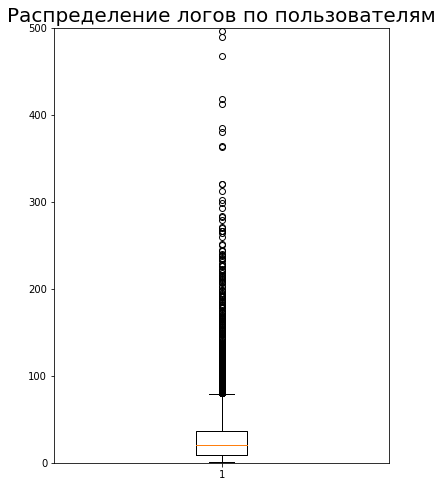

In [17]:
#задаём графическую область plt.subplots() 
fig1,ax1 =  plt.subplots(figsize=(6,8))
#название графика определяет set_title() 
ax1.set_title('Распределение логов по пользователям', fontsize=20) 
ax1.boxplot(log_data['device_id_hash'].value_counts())
#ограничим ось Y, чтоюы более детально видеть график 
ax1.set_ylim(0,500)

На большинство пользователей в среднем приходится не большее 100 логов, но есть и пользователи с средним числом 500,1000,1500 и даже более 2000 логов. 

#### 3.4. Работа с  данными времени <a id="time"></a>

Узнаем период всех данных, для этого выделим максимальную и минимальную дату.

In [18]:
min_date=log_data['event_datetime'].min()
max_date=log_data['event_datetime'].max()
total=(max_date-min_date)
print(f'Период данных составляет {total.days} дней: c {min_date} по {max_date}')

Период данных составляет 13 дней: c 2019-07-25 04:43:36 по 2019-08-07 21:15:17


Построим гистограмму по дате и времени, чтобы выяснить одинаково ли полные данные за весь период.

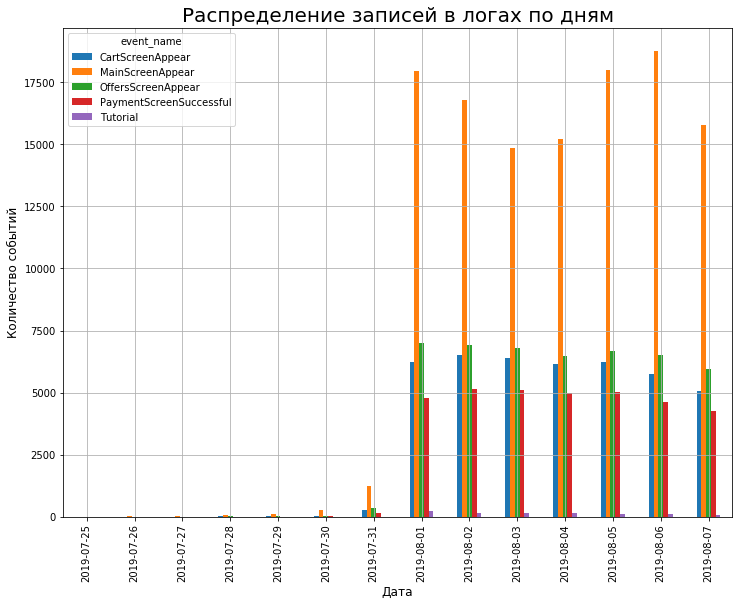

In [19]:
#создаём сводную таблицу, где индексы - дата, столбцы - виды событий, а значения - подсчёт количества пользователя  
logs_by_date = log_data.pivot_table(index='date', columns = 'event_name', values='device_id_hash', aggfunc='count')
#создаём столбчатую диаграмму kind=bar
logs_by_date.plot(kind = 'bar', figsize = (12,9))
plt.title('Распределение записей в логах по дням', fontsize=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.xticks(rotation = 90)
plt.grid();

Видно,что впервую неделю данных почти нет, поэтому чтобы не нарушить результаты статистическиго теста, выделяем правильный момент полноты дынных, отбросив более старые дни.

In [20]:
#делаем срез данных по августу месяцу и сохраняем результат в log_data_right 
log_data_right=log_data[pd.to_datetime(log_data['date']).dt.month == 8]
#проверяем количество оставшихся логов 
len(log_data_right)

240887

Число логов уменьшилось. Проверим насколько сильно произошли изменения в данных.

In [21]:
#посчитаем количество логов каждого вида событий в отсортированных данных, применяя .value_counts()
#также уберем названия событий из индексов при помощи .reset_index(), сохраняем данные в event_logs_right 
event_logs_right=log_data_right['event_name'].value_counts().reset_index()
#переименуем столбцы методом .columns
event_logs_right.columns=['event_name','count_events_right']
#отсортируем наименования событий по алфавиту .sort_values('event_name')
event_logs_right=event_logs_right.sort_values('event_name')
event_logs_right

,event_name,count_events_right
2,CartScreenAppear,42303
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [22]:
#объединяем event_logs и event_logs_right по столбцу 'event_name'
event_logs=event_logs_right.merge(event_logs, on='event_name')
#рассчитываем процентное соотношение изменений 
event_logs['lost_events']=(event_logs['count_events']-event_logs['count_events_right'])/event_logs['count_events']*100
#смотрим итогувую таблицу
event_logs

,event_name,count_events_right,count_events,lost_events
0,CartScreenAppear,42303,42668,0.855442
1,MainScreenAppear,117328,119101,1.488652
2,OffersScreenAppear,46333,46808,1.014784
3,PaymentScreenSuccessful,33918,34118,0.586201
4,Tutorial,1005,1018,1.277014


Потеря данных в любом виде событий не составляет больше 1,5 процента, следовательно такие ограничение на диапозон событий не составляют больших помех.

In [23]:
#теперь проверим какой процент пользователей потерян
print('Процент потерянных пользователей в логах: ', round((1-log_data_right['device_id_hash'].nunique()/log_data['device_id_hash'].nunique()), 3)*100)
#определим абсолютное значение потерянных пользователей
print('Число потерянных пользователей: ', (log_data['device_id_hash'].nunique()-log_data_right['device_id_hash'].nunique()))

Процент потерянных пользователей в логах:  0.2
Число потерянных пользователей:  17


In [24]:
#теперь проверим какой процент пользователей потерян
print('Общий процент потерянных данных: ', round((1-len(log_data_right)/len(log_data)), 4)*100)
#определим абсолютное значение потерянных данных
print('Число потерянных логов: ', (len(log_data)-len(log_data_right)))

Общий процент потерянных данных:  1.16
Число потерянных логов:  2826


#### 3.5. Проверим, что у нас есть пользователи из всех трёх экспериментальных групп, чтобы начать работу с A/A/B тестом <a id="check_users_for_test"></a>

In [25]:
#применяем методом unique() к столбцу 'exp_id',чтобы получить все виды групп для теста
print('Виды групп для A/A/B теста: ', log_data_right['exp_id'].unique())

Виды групп для A/A/B теста:  [246 247 248]


In [26]:
#проверяем распредление данных по группам
log_data_right.groupby('exp_id').agg({'device_id_hash': 'nunique'})

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


### Вывод

Таким образом, после проведенного предварительного анализа был определен диапозон данных, когда события в каждый день максимально полны. Потеря данных составила лишь 1,16%, а период данных на самом деле составляет с 1 августа-7 августа.

## 4. Воронка событий <a id="funnel_of_events"></a>

#### 4.1. Обзор событий в логах <a id="overview_events"></a>


Определим частоту каждого вида событий, как отношение числа событий группы к общему числу всех событий.

In [27]:
#ранее уже получали event_logs_right, который содержит количество логов вида событий событий
#поделим стлобец 'count_events_right' на общее число событий, найденных методом len(log_data_right), для получения частоты
event_logs_right['frequency']=(event_logs_right['count_events_right']/len(log_data_right)).round(3)
#сортируем события по частоте sort_values() 
event_logs_right=event_logs_right.sort_values('frequency') 
event_logs_right

,event_name,count_events_right,frequency
4,Tutorial,1005,0.004
3,PaymentScreenSuccessful,33918,0.141
2,CartScreenAppear,42303,0.176
1,OffersScreenAppear,46333,0.192
0,MainScreenAppear,117328,0.487


Почти половина логов/действий - переход пользователей на главнй экран, и только 19, 18 и 14 процентов действий - переход к предложениям, добавленя товаров в корзину и непосредственна оплата покупки товара. Такая разница в долевом/процентном соотношении означает,что меньше половины от всех пользователей преступает к покупкам товаров. А обучение занимает лишь 0,4% всех данных, следовательно логично предположить что очень мало переходят к непосредственному обучению, но это не проблема, так как цель стартапа-продать продукт.

#### 4.2. Работа с пользователями, которые совершают  события <a id="work_with_users"></a>

Определим количество пользователей, которые совершали каждое из видов событий, а также посчитаем долю пользователей, которые хоть раз совершали событие.

In [28]:
#сгруппируем данные по событиям и для каждого из них посчитаем число уникальных пользователей
event_users=(log_data_right.groupby('event_name', as_index=False)
             .agg({'device_id_hash':'nunique'})
             .sort_values('device_id_hash')
             .rename(columns={'device_id_hash':'count_users'})
            )
#сохраняем бщее число пользователей в переменную total_users
total_users=log_data_right['device_id_hash'].nunique()
#поделим стлобец 'count_users' на 'total_users' для получения доли пользователей, которые хоть раз совершали событие
event_users['part']=(event_users['count_users']/total_users).round(3)
#сортируем события по доли sort_values() 
event_users=event_users.sort_values('count_users') 
event_users

,event_name,count_users,part
4,Tutorial,840,0.111
3,PaymentScreenSuccessful,3539,0.470
0,CartScreenAppear,3734,0.496
2,OffersScreenAppear,4593,0.610
1,MainScreenAppear,7419,0.985


Можно отметить, что не для всех пользователей все события выстраиваются в последовательную цепочку. 1,5% пользователей пропускают главный экран и , возможно, сразу переходят к предложениям. 

#### 4.3. Порядк событий <a id="order_of_events"></a>

По долевому отношению можно предположить,что пользователи придерживаются следующей цепочки действий: главный экран-предложения-корзина-оплата-обучение. 


Однако мы не знаем, все ли из пользователей, дошедших до покупки-обучения, придерживались данной последовательности действий. Для этого отследим последовательность действий по первому времени совершения события каждого пользователя.

In [29]:
#создадим сводную таблицу users , где индекс- айди пользователя, столбцы - события, а значение первое время совершения события
users = log_data_right.pivot_table(
        index='device_id_hash', 
        columns='event_name', 
        values='event_datetime',
        aggfunc='min')
users.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
device_id_hash,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


Пропущенные значения Nan значат лишь то,что пользователь не приступал к данному событию.

Для начала посчитаем количество пользователей, которые перешли на главную страницу сайта. Для этого находим число строк таблицы users, где в столбце MainScreenAppear не стоит пустое значение.

In [30]:
# создаём срез данных при помощи отрицания ~ всех строк главной страницы с NaN
#затем определяем размер таблицы при помощи shape[0]
n_main = users[~users['MainScreenAppear'].isna()].shape[0]
print('Посетителей главного экрана:', n_main)

Посетителей главного экрана: 7419


Затем определяется, сколько людей из тех, кто переходил на главный экран сайта, перешел к предложениям. То есть мы отбираем пользователей, во-первых, у которых есть дата посещения главного экрана сайта, а во-вторых, дата события "просмотрена страницы предложений" позже даты первого захода на главную страницу сайта.

In [31]:
n_offers = users[~users['MainScreenAppear'].isna() & (users['OffersScreenAppear'] > users['MainScreenAppear'])].shape[0]
print('Увидели предложения:', n_offers)

Увидели предложения: 4201


Аналогично добавим остальные шаги и получим число пользователей для каждого шага воронки.

In [32]:
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])
step_5 = step_4  & (users['Tutorial'] > users['PaymentScreenSuccessful'])
#фильтруем данные users  и методом .shape[0] определяем число пользователей
n_main = users[step_1].shape[0]
n_offers = users[step_2].shape[0]
n_cart = users[step_3].shape[0]
n_payment = users[step_4].shape[0]
n_tutorial = users[step_5].shape[0]

print('Посетители главного сайта:', n_main)
print('Посетители, которые увидели предложения:', n_offers)
print('Добавили товара в корзину:', n_cart)
print('Оплатили:', n_payment)
print('Перешли к обучению:', n_tutorial)

Посетители главного сайта: 7419
Посетители, которые увидели предложения: 4201
Добавили товара в корзину: 1767
Оплатили: 454
Перешли к обучению: 1


In [33]:
event_users.sort_values('part', ascending=False)

,event_name,count_users,part
1,MainScreenAppear,7419,0.985
2,OffersScreenAppear,4593,0.610
0,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470
4,Tutorial,840,0.111


Количество пользователей на первом шаге совпадает с число пользователей из подсчета числа событий, но дальше, начиная с добавления продукта в корзину, начинаются большие  расхождения. Это значит, что далеко не все пользователи придерживаются ожидаемому пути, а могут идти сразу от главного экрана к корзине или иным способом, например возвращаются на предыдущий шаг и снова возвращаются к корзине. Лишь 1 пользователь, следуя выдвинутой цепи, доходит до обучения, но это не значит, что цепь построена не верно. Главная цель приложения - продать продукт, а значит отследить момент покупки, поэтому учитывать в воронке 'tutorial' мы просто не будем.

#### 4.4. Работа с  воронкой событий <a id="work_with_funnel"></a>

Для начало работы построим воронку событий без учета последовательности событий.

In [34]:
#построим таблицу для воронки event_funnel
event_funnel=pd.DataFrame(data={'event_name':  ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'],
                                'count_users': [7419, 4593, 3734, 3539] })
event_funnel 

,event_name,count_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


По построенной воронке, посчитаем долю пользователей, которые проходят на следующий шаг воронки (от числа пользователей на предыдущем). 

In [36]:
conversions=[]
for i in range(len(event_funnel )):
    if i == 0:
        conversions.append(100)
    else:
        conversions.append(round(event_funnel.loc[i,'count_users']/event_funnel.loc[i-1,'count_users']*100,0))
event_funnel['conversion']=conversions
event_funnel

,event_name,count_users,conversion
0,MainScreenAppear,7419,100.0
1,OffersScreenAppear,4593,62.0
2,CartScreenAppear,3734,81.0
3,PaymentScreenSuccessful,3539,95.0


### Вывод

Меньше половины пользователей доходят до этапа оплаты: 48% доходят с момента перехода на главную страницу до страницы с оплатой. Причём больше всего пользователей теряется на шаге перехода с главного экрана к предложениям. Такое являние может быть связано с тем,что пользователей мог не удовлетворить интерфейс страницы, её оформление или удобство с работой. Поэтому если провести дополнительный анализ этого шага и провести интервью с пользователем, можно будет увеличить число потербителей продукта, так как с оплатой продукта проблем нет.  

## 5.  Анализ результата A/A/B теста <a id="analytic_test"></a>

#### 5.1. Обзор пользователей в каждой экспериментальной группе <a id="overview_group"></a>

In [37]:
#проверяем распредление данных по группам
group=log_data_right.groupby('exp_id').agg({'device_id_hash': 'nunique'})
group

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


#### 5.2. Статистический анализ между выборками 246 и 247 <a id="analytic_control_group"></a>

Статистический анализ групп будем проводить по долевому отношений пользователей, которые совершили конкретное событие.

In [38]:
#отбираем группы вск кроме  248 и не берем в счёт Tutorial (ранее мы это уже обсуждали)
#создаём сводную таблицу, где  индексы-события,а столбцы- контрольные группы , в которых хранится уникальное число пользователей
#сортируем данные сразу в порядке убывания и сохраняем в control_test
control_test=(log_data_right[(~(log_data_right['exp_id']== 248)) & (~(log_data_right['event_name']=='Tutorial'))]
              .pivot_table(index='event_name',
                           columns='exp_id', 
                           values='device_id_hash',
                           aggfunc='nunique')
              .sort_values(246, ascending=False)
             )
#затем поделим сзнаения столбцов на общее число всех уникальных пользователей,чтобы рассчитать долевое соотошение
A1_total=group.loc[246,'device_id_hash']
A2_total=group.loc[247,'device_id_hash']
control_test.columns=['A1', 'A2']
control_test=control_test.reset_index()
control_test

,event_name,A1,A2
0,MainScreenAppear,2450,2476
1,OffersScreenAppear,1542,1520
2,CartScreenAppear,1266,1238
3,PaymentScreenSuccessful,1200,1158


Создаём функцию для рассчёта уровня значимости отличия долевых соотношений для определенного события. Расчёт будем вести через z-значения. События воронки- отдельные метрики для одних и тех же двух групп, поэтому понижать критический уровень значимости не будем.  

H0-долевые отношения котрольных групп не отличаются, H1- есть различия между долевыми отношениями контрольных групп.  

In [39]:
def function(A1, A2, A1_total, A2_total, alpha):
       
    # пропорция успехов в первой группе:
    p1 = A1/A1_total

    # пропорция успехов во второй группе:
    p2 = A2/A2_total
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (A1 + A2)/ (A1_total + A2_total)

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/A1_total + 1/A2_total))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value.round(2))

    if (p_value < alpha):
        return ("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        return ("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")        

In [40]:
#сохраняем ответ в список answer
answer=[]
alpha = .05 # критический уровень статистической значимости
#создаём цикл по прохождению каждого события
for i in range(len(control_test)):
    answer.append(function(control_test.loc[i,'A1'], control_test.loc[i,'A2'], A1_total, A2_total, alpha))
#сохраняем ответ в колонку 'result_test'    
control_test['result_test']=answer    
control_test    

p-значение:  0.76
p-значение:  0.25
p-значение:  0.23
p-значение:  0.11


,event_name,A1,A2,result_test
0,MainScreenAppear,2450,2476,"Не получилось отвергнуть нулевую гипотезу, нет..."
1,OffersScreenAppear,1542,1520,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,CartScreenAppear,1266,1238,"Не получилось отвергнуть нулевую гипотезу, нет..."
3,PaymentScreenSuccessful,1200,1158,"Не получилось отвергнуть нулевую гипотезу, нет..."


Ни для одного из событий уровень значимости не упал ниже критического, а значит мы не можем утверждать,что у нас есть такие и более значимые различия между долевыми соотношениями контрольных групп.

#### 5.3. Статистический анализ группы с изменённым шрифтом 248 с контрольными группами в отдельности по каждому событию <a id="analytic_all_group"></a>

In [41]:
#отбираем группы все и  не берем в счёт Tutorial (ранее мы это уже обсуждали)
#создаём сводную таблицу, где  индексы-события,а столбцы- контрольные группы , в которых хранится уникальное число пользователей
#сортируем данные сразу в порядке убывания и сохраняем в control_test
test=(log_data_right[(~(log_data_right['event_name']=='Tutorial'))]
              .pivot_table(index='event_name',
                           columns='exp_id', 
                           values='device_id_hash',
                           aggfunc='nunique')
              .sort_values(246, ascending=False)
             )
#затем поделим сзнаения столбцов на общее число всех уникальных пользователей,чтобы рассчитать долевое соотошение
A1_total=group.loc[246,'device_id_hash']
A2_total=group.loc[247,'device_id_hash']
B_total=group.loc[248,'device_id_hash']
test.columns=['A1', 'A2', 'B']
test=test.reset_index()
test['A']=test['A1']+test['A2']
test

,event_name,A1,A2,B,A
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


Так как сравнения будут идти среди нескольких групп одной совокупности:  A1 и B, A2 и B, A и B- и так как таких групп всего 3, то следуя поправке Бонферрони, делим критический уровень значимость на 3.  

H0-долевые отношения между котрольнымы группами и группой, у который шрифт изменили, не отличаются, H1- есть различия долевых отношений между контрольными группами и группой, у который шрифт изменили.

In [42]:
alpha_ben = alpha/3 # критический уровень статистической значимости
#сохраняем ответ в список answer
A1_B=[]
A2_B=[]
A_B=[]
#создаём цикл по прохождению каждого события
for i in range(len(test)):
    A1_B.append(function(test.loc[i,'A1'],test.loc[i,'B'], A1_total, B_total, alpha_ben))
    A2_B.append(function(test.loc[i,'A2'], test.loc[i,'B'], A2_total, B_total, alpha_ben))
    A_B.append(function(test.loc[i,'A'], test.loc[i,'B'], A1_total+A2_total, B_total, alpha_ben))
#сохраняем ответ в колонку 'result_test'    
test['result_test_A1_B']=A1_B    
test['result_test_A2_B']=A2_B  
test['result_test_A_B']=A_B  
test   

p-значение:  0.29
p-значение:  0.46
p-значение:  0.29
p-значение:  0.21
p-значение:  0.92
p-значение:  0.43
p-значение:  0.08
p-значение:  0.58
p-значение:  0.18
p-значение:  0.21
p-значение:  0.74
p-значение:  0.6


,event_name,A1,A2,B,A,result_test_A1_B,result_test_A2_B,result_test_A_B
0,MainScreenAppear,2450,2476,2493,4926,"Не получилось отвергнуть нулевую гипотезу, нет...","Не получилось отвергнуть нулевую гипотезу, нет...","Не получилось отвергнуть нулевую гипотезу, нет..."
1,OffersScreenAppear,1542,1520,1531,3062,"Не получилось отвергнуть нулевую гипотезу, нет...","Не получилось отвергнуть нулевую гипотезу, нет...","Не получилось отвергнуть нулевую гипотезу, нет..."
2,CartScreenAppear,1266,1238,1230,2504,"Не получилось отвергнуть нулевую гипотезу, нет...","Не получилось отвергнуть нулевую гипотезу, нет...","Не получилось отвергнуть нулевую гипотезу, нет..."
3,PaymentScreenSuccessful,1200,1158,1181,2358,"Не получилось отвергнуть нулевую гипотезу, нет...","Не получилось отвергнуть нулевую гипотезу, нет...","Не получилось отвергнуть нулевую гипотезу, нет..."


#### Вывод

Как видно, ни один уровень значемости не стал меньше критического уровня значимости(ошибки первого рода), поэтому отвергнуть нулевую гипотезу нельзя, то есть шрифт никак не влияет на пользовательские метрики.  

## Общий вывод <a id="conclusion"></a>

В результате анализа было выяснено,что больше всего теряется пользователей на этапе перехода с главной страницы к странице с предложениями(38%). Техникам сотит проверить качество работы кода перехода на страницы, а маркетологам стоит провести дополнительное интервью пользователей по работе с интерфейсом, возможно , проблема связана с неудоством работы или не привлекательным внешним видом.

Анализ A/A/B-теста показал,что изменение шрифта не показало значимых различий от контрольных групп. Часто изменение шрифта не увеличивается пользовательский спрос. Изменить цвет или размер надписи может повлиять на конечный результат, но для этого нужно провести дополнительный тест.